In [112]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import h3pandas
import numpy as np

In [102]:
gdf = gpd.read_file("./data/pde2014.geojson")
gdf = gdf.h3.geo_to_h3(9).reset_index().reset_index().rename(columns={"h3_09": "id_hex", "index": "id"})
gdf.head(3)

,id,id_hex,categoria_de_uso_registro,legislacao,has_his,geometry
0,0,89a8100d55bffff,HIS 2,PDE2014eLPUOS2016,True,POINT (-46.57370 -23.56345)
1,1,89a8100d4b3ffff,HIS 2,PDE2014eLPUOS2016,True,POINT (-46.57476 -23.57687)
2,2,89a8100d5cbffff,H.I.S,PDE2014eLPUOS2016,True,POINT (-46.57853 -23.56656)


### PDE zones

In [103]:
eetu = gpd.read_file("./data/EETU/sirgas_PDE_3-Eixos-EETU.shp")
eetu.crs = 31983
eetu = eetu.to_crs(4326)

In [104]:
zeis1 = gpd.read_file("./data/ZEIS/sirgas_PDE_4-Zeis1.shp")
zeis1.crs = 31983
zeis1 = zeis1.to_crs(4326)

zeisOthers = gpd.read_file("./data/ZEIS/sirgas_PDE_4A-Zeis2,3,4,5.shp")
zeisOthers.crs = 31983
zeisOthers = zeisOthers.to_crs(4326)

zeis = pd.concat([zeis1, zeisOthers], ignore_index=True)
len(zeis), len(zeis1), len(zeisOthers), len(eetu)

(2571, 1401, 1170, 4818)

In [105]:
gdf['zeis'] = False
gdf['eetu'] = False
zeisIntersection = gpd.overlay(gdf, zeis)['id'].unique()
gdf.loc[gdf['id'].isin(zeisIntersection), 'zeis'] = True
eetuIntersection = gpd.overlay(gdf, eetu)['id'].unique()
gdf.loc[gdf['id'].isin(eetuIntersection), 'eetu'] = True

gdf.head(3)

,id,id_hex,categoria_de_uso_registro,legislacao,has_his,geometry,zeis,eetu
0,0,89a8100d55bffff,HIS 2,PDE2014eLPUOS2016,True,POINT (-46.57370 -23.56345),False,False
1,1,89a8100d4b3ffff,HIS 2,PDE2014eLPUOS2016,True,POINT (-46.57476 -23.57687),True,False
2,2,89a8100d5cbffff,H.I.S,PDE2014eLPUOS2016,True,POINT (-46.57853 -23.56656),False,False


### Accessibility data
##### Selecting São Paulo in 2019 by public transport

In [106]:
useCols = ["CMATT30", "CMATT60", "CMATT90", "CMATT120", "mode", "abbrev_muni", "year", "peak", "id_hex"]
access = pd.read_csv("./data/aop_access_publictransport_2019_v2.csv", usecols=useCols)
access = access[
    (access.abbrev_muni == 'spo') & (access['mode'] == 'public_transport') & (access.year == 2019) & (access.peak == 1)
].reset_index(drop=True)
access.head(3)

,year,id_hex,abbrev_muni,mode,peak,CMATT30,CMATT60,CMATT90,CMATT120
0,2019,89a81000003ffff,spo,public_transport,1,4797.0,96195.0,1168463.0,2136716.0
1,2019,89a81000007ffff,spo,public_transport,1,4228.0,72810.0,1088120.0,2095040.0
2,2019,89a8100000bffff,spo,public_transport,1,2648.0,147237.0,1428750.0,2203072.0


In [107]:
gdf = gdf.merge(access, on="id_hex", how="left")
gdf.head(3)

,id,id_hex,categoria_de_uso_registro,legislacao,has_his,geometry,zeis,eetu,year,abbrev_muni,mode,peak,CMATT30,CMATT60,CMATT90,CMATT120
0,0,89a8100d55bffff,HIS 2,PDE2014eLPUOS2016,True,POINT (-46.57370 -23.56345),False,False,2019,spo,public_transport,1,82921.0,1136320.0,2513861.0,3294191.0
1,1,89a8100d4b3ffff,HIS 2,PDE2014eLPUOS2016,True,POINT (-46.57476 -23.57687),True,False,2019,spo,public_transport,1,82726.0,1252081.0,2730050.0,3354754.0
2,2,89a8100d5cbffff,H.I.S,PDE2014eLPUOS2016,True,POINT (-46.57853 -23.56656),False,False,2019,spo,public_transport,1,54077.0,878863.0,2392554.0,3163478.0


### Plot

In [191]:
def accessHistograms(gdf, weighted=False):

    """
        gdf: all the records of buildings
        variable: accessibility measurement associated to the hex_id
        weighted: True if should compute records more than once if they are within the same hex_id
    """

    fig, axes = plt.subplots(2,2) 

    yValues = np.arange(0, 36, 6)

    i = 0
    rows = [0, 0, 1, 1]
    cols = [0, 1, 0, 1]

    for variable in ["CMATT30", "CMATT60", "CMATT90", "CMATT120"]:

        plotDF = gdf.copy()

        if weighted == False: 
            plotDF = gdf.drop_duplicates(["id_hex", "has_his"])
    
        plotDF['HIS'] = plotDF[variable].copy()
        plotDF['HIS EETU'] = plotDF[variable].copy()
        plotDF['HIS ZEIS'] = plotDF[variable].copy()
        plotDF['Outros'] = plotDF[variable].copy()
        
        plotDF.loc[plotDF.has_his==False, 'HIS'] = None
        eetuIDXs = plotDF[(plotDF.eetu == True) & (plotDF.has_his==True)]['id_hex'].unique()
        zeisIDXs = plotDF[(plotDF.zeis == True) & (plotDF.has_his==True)]['id_hex'].unique()
        plotDF.loc[~plotDF.id_hex.isin(eetuIDXs), 'HIS EETU'] = None
        plotDF.loc[~plotDF.id_hex.isin(zeisIDXs), 'HIS ZEIS'] = None
        plotDF.loc[(plotDF.has_his==True), 'Outros'] = None

        boxplotColor = 'black'

        row = rows[i]
        col = cols[i]
        
        plotDF[['Outros', 'HIS', 'HIS EETU', 'HIS ZEIS']].plot.box( 
            figsize=(13,13), #markerface=dict(means=boxplotColor),
            color=dict(boxes=boxplotColor, whiskers=boxplotColor, medians=boxplotColor, caps=boxplotColor),
            boxprops=dict(linewidth=2.3), showfliers=False, showmeans=True,
            whiskerprops=dict(linestyle='-', linewidth=2.3), ax=axes[row, col],
            meanprops=dict(marker='D', markeredgecolor=boxplotColor, markerfacecolor=boxplotColor)
        ) 

        

        variable_timedelta = variable.split("TT")[-1]
        axes[row, col].set_title('até '+str(variable_timedelta)+' minutos', fontsize=16)
        axes[row, col].tick_params(labelsize=18)
        axes[row, col].yaxis.offsetText.set_visible(False)

        #axs[0].set_xlabel('distance (m)')
        axes[row, col].set_ylabel("Empregos acessíveis (x10e5)", fontsize=13, labelpad=14)
        axes[row, col].set_xlabel("", rotation=45, ha='right')

        axes[row, col].set_yticks(yValues*10e4, [val for val in yValues])
        
        #plt.ylabel("Empregos acessíveis" + "  " + '(x10e5)', fontsize=13, labelpad=23)
        #plt.xticks(rotation=45, ha='right')

        
        #plt.yticks(yValues*10e4, [val for val in yValues])

        i+=1
    
    fig.suptitle('Acessibilidade via transporte público', fontsize=19)
    plt.savefig("./plot/histogram/accessibility_weighted"+str(weighted)+".png")
    
    return 

/Users/camillaperotto/Documents/his-sp/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/camillaperotto/Documents/his-sp/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/camillaperotto/Documents/his-sp/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying t

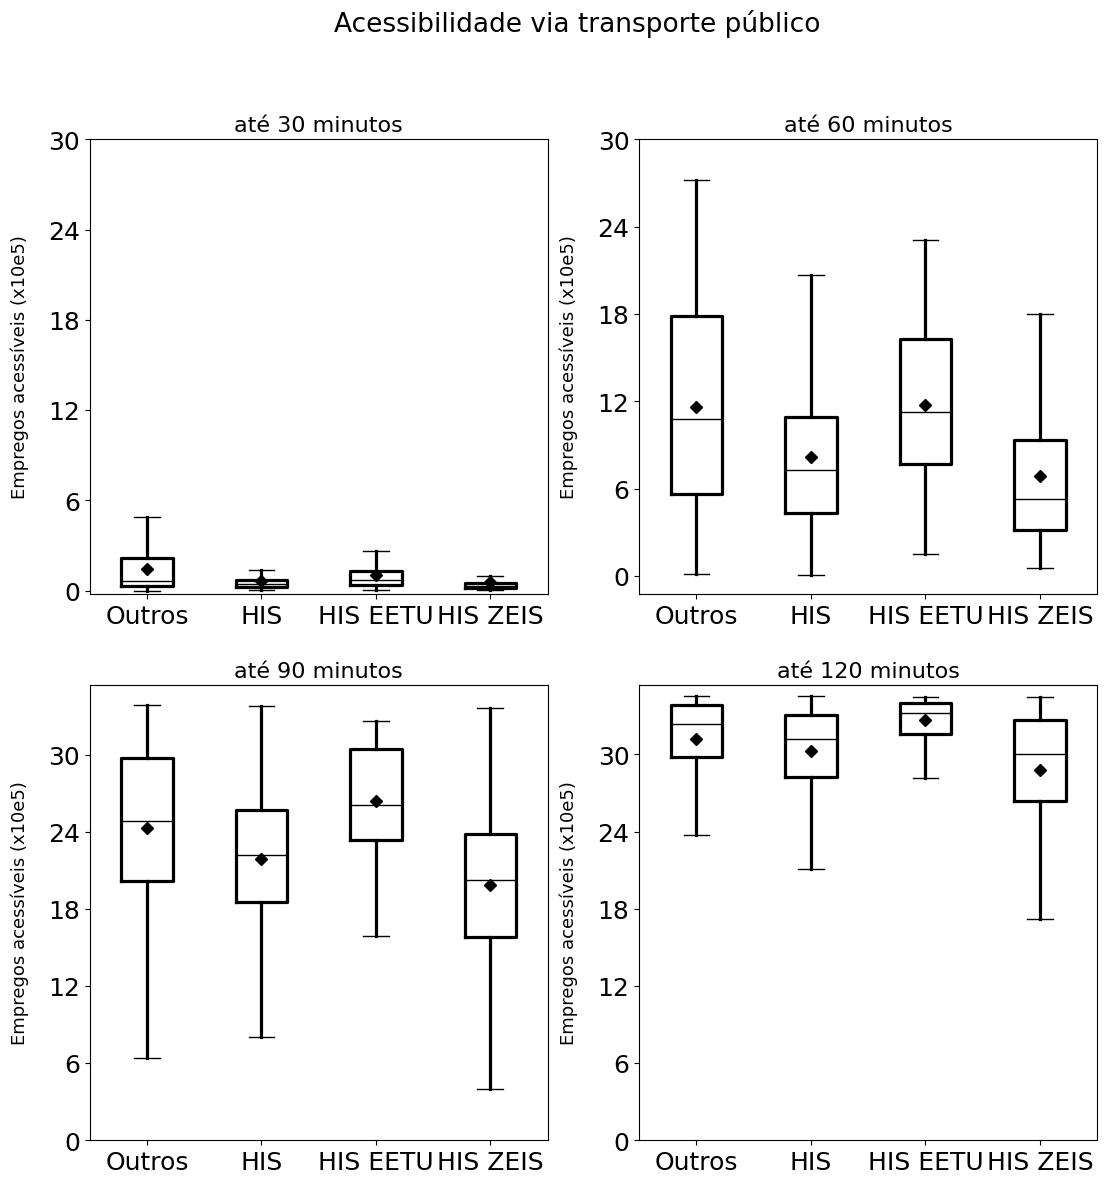

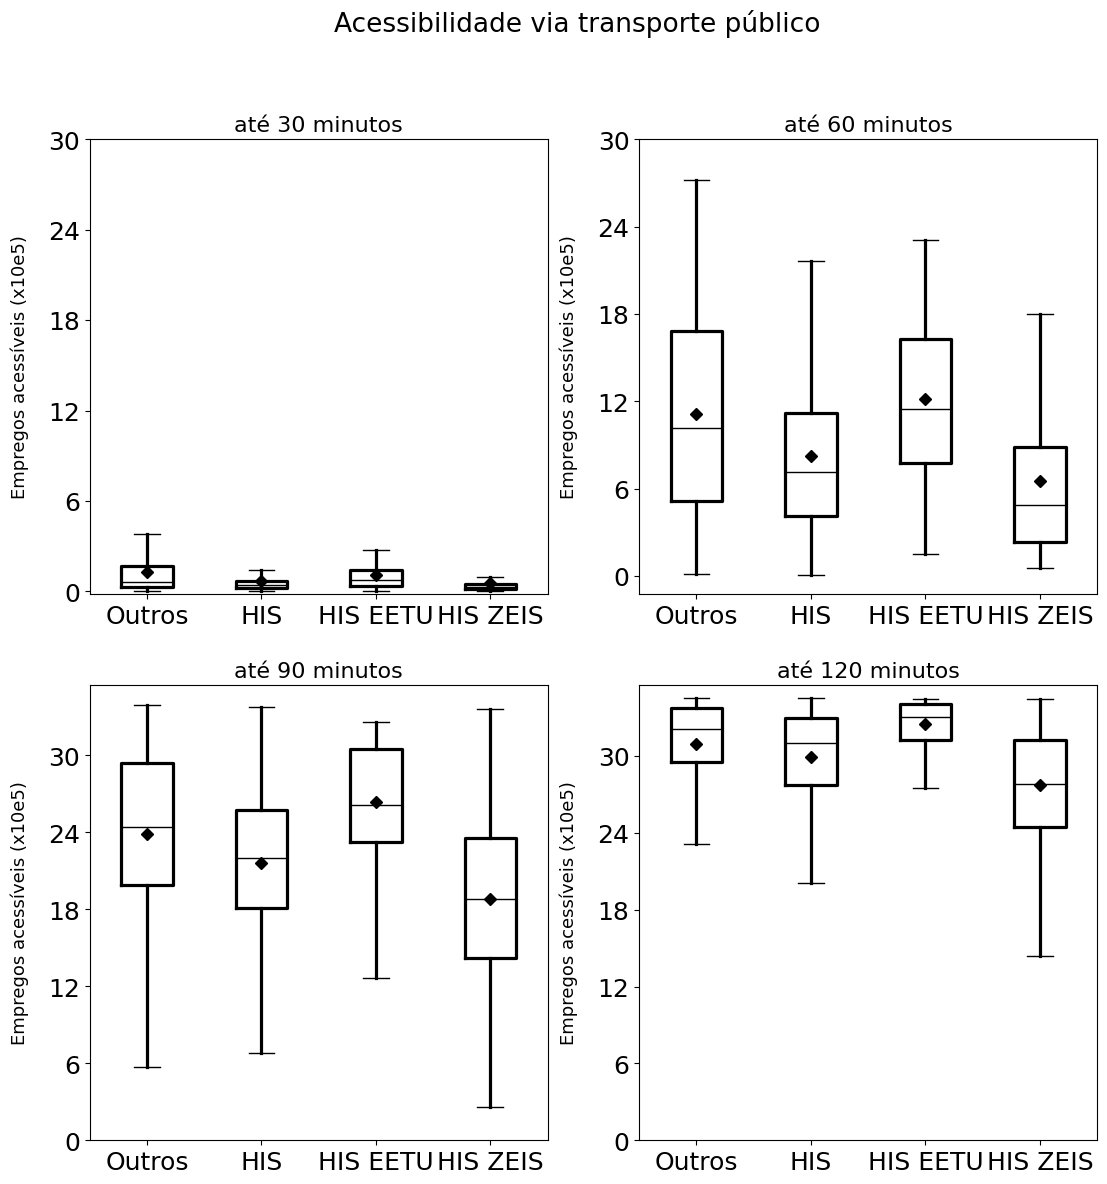

In [192]:
for weighted in [True, False]: accessHistograms(gdf, weighted)